In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HUGGINGFACEHUB_API_TOKEN")

# 失敗的話會列印出：'沒讀到 HUGGINGFACEHUB_API key'
os.environ["HUGGINGFACEHUB_API_TOKEN"]

## Read the Documents

In [2]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

doc_list = []
y_true = []

for i in range(1, 51):
    with open(f"./News/semiconductor/content/{i}.txt", 'r', encoding='UTf-8') as file:
        doc_list.append(file.read())
        y_true.append(1)  # semiconductors

for i in range(1, 51):
    with open(f"./News/industrial_automation/content/{i}.txt", 'r', encoding='UTf-8') as file:
        doc_list.append(file.read())
        y_true.append(2)  # industrial automation

for i in range(1, 51):
    with open(f"./News/ev/content/{i}.txt", 'r', encoding='UTf-8') as file:
        doc_list.append(file.read())
        y_true.append(3)  # ev

for i in range(1, 51):
    with open(f"./News/AI_supplement/content/{i}.txt", 'r', encoding='UTf-8') as file:
        doc_list.append(file.read())
        y_true.append(4)  # AI

## Zero-Shot Classification

In [3]:
from langchain.llms import HuggingFaceEndpoint
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from tqdm import tqdm


llm = HuggingFaceEndpoint(repo_id="mistralai/Mistral-7B-Instruct-v0.2", max_new_tokens=4096, temperature=0.1)

user_template = """
You are a professional business analyst. Please help me classify by industry the following news delimited by <news> tags.
The possible industries are semiconductors, industrial automation, electric vehicle, and AI.

<news>
{news}
</news>

The output format is as follows, in JSON.

{{"category": <INTEGER_category>}}

The <INTEGER_category> to choose from are semiconductors (category: 1), industrial automation (category: 2), eletric vehicle (category: 3), and AI (category: 4).
Please output the category number ranging from 1 to 4, rather than the category name.
Each news must belong to EXACTLY one category.
Please ONLY output the json and nothing else. You should strictly adhere to the output format!

Below is an example of a valid output:
{{"category": 4}}
"""

zeroshot_prompt = ChatPromptTemplate.from_messages([
    ("user", user_template)
])

C:\Users\ducky\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from langchain-huggingface package and should be used instead. To use it run `pip install -U from langchain-huggingface` and import as `from from langchain_huggingface import llms import HuggingFaceEndpoint`.
  warn_deprecated(


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to C:\Users\ducky\.cache\huggingface\token
Login successful


In [4]:
zeroshot_chain = zeroshot_prompt | llm

test_news = doc_list[123]
test_answer = zeroshot_chain.invoke({"news": test_news})
print(test_answer)


Based on the provided news text, the output would be:
{"category": 3}


In [5]:
class Category(BaseModel):
    categoy: int = Field(description="the category number that the piece of news belongs to")


def get_json(text: str) -> str:
    index_start = text.find('{"')
    index_end = text.find('}', index_start)
    return text[index_start : (index_end + 1)]
        

parser = JsonOutputParser(pydantic_object=Category)
zeroshot_chain = zeroshot_prompt | llm | get_json | parser

test_news = doc_list[123]
test_answer = zeroshot_chain.invoke({"news": test_news})
print(test_answer)

{'category': 3}


In [6]:
y_pred = []

for doc in tqdm(doc_list):
    try:
        answer = zeroshot_chain.invoke({"news": doc})
        assert((1 <= answer["category"] and answer["category"] <= 4))
        y_pred.append(answer["category"])
    except:
        y_pred.append(0)

print("Number of invalid classifications:", y_pred.count(0))

100%|██████████| 200/200 [03:12<00:00,  1.04it/s]

Number of invalid classifications: 6


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.96      1.00      0.98        50
           2       0.98      0.88      0.93        50
           3       0.93      1.00      0.96        50
           4       0.98      0.84      0.90        50

    accuracy                           0.93       200
   macro avg       0.77      0.74      0.75       200
weighted avg       0.96      0.93      0.94       200



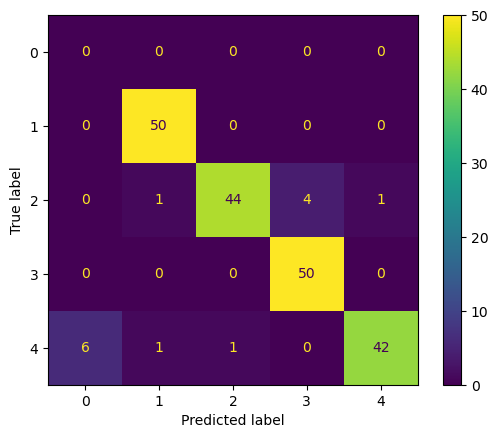

In [7]:
print(classification_report(y_true, y_pred, zero_division=0.0))
confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
confusion_mat.plot()
plt.show()

## Dealing with Invalid Output

In [8]:
from langchain_core.prompts import ChatPromptTemplate

user_failed_template = """
The output format is illegal! Please re-generate a correct output.

The output format is as follows, in JSON.

{{"category": <INTEGER_category>}}

The <INTEGER_category> to choose from are semiconductors (category: 1), industrial automation (category: 2), eletric vehicle (category: 3), and AI (category: 4).
Please output the category number ranging from 1 to 4, rather than the category name.
Each news must belong to EXACTLY one category.
Please ONLY output the json and nothing else. 
"""


zeroshot_failed_prompt = ChatPromptTemplate.from_messages([
        ("user", user_template),
        ("ai", "{model_output}"),
        ("user", user_failed_template)
    ])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to C:\Users\ducky\.cache\huggingface\token
Login successful


100%|██████████| 200/200 [00:55<00:00,  3.62it/s]

Number of invalid classifications: 2
Failed Outputs:
['\nI apologize for the confusion earlier. Based on the provided news, I cannot determine a clear industry classification. The news is about a podcast episode discussing the biggest events of 2023 in the tech industry, and it mentions SVB, SBF, OpenAI, and some other companies. However, none of these companies are exclusively associated with semiconductors, industrial automation, electric vehicle, or AI industries. Therefore, I cannot classify this news into any of the given categories.\n\n{"category": 0}', '\n<news>\nTikTok loves e-commerce and VCs think Mistral AI will be fine (potential EU regulatory overhang or not)  Listen here or wherever you get your podcasts. Hello, and welcome back to Equity, the podcast about the business of startups, where we unpack the numbers and nuance behind the headlines. Our Monday show covers the latest in tech news from the weekend and what’s making headlines early in the week. Alex is a little bit

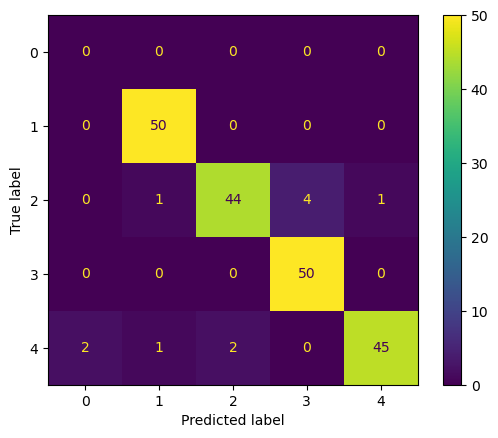

In [9]:
y_pred = []
failed_output = []

for doc in tqdm(doc_list):
    try:
        llm_output_chain = zeroshot_prompt | llm
        llm_output = llm_output_chain.invoke({"news": doc})
        json_chain = get_json | parser
        answer = json_chain.invoke(llm_output)
        assert((1 <= answer["category"] and answer["category"] <= 4))
        y_pred.append(answer["category"])
    except:
        try:
            llm_output_chain = zeroshot_failed_prompt | llm
            llm_output = llm_output_chain.invoke({"news": doc, "model_output": llm_output})
            json_chain = get_json | parser
            answer = json_chain.invoke(llm_output)
            assert((1 <= answer["category"] and answer["category"] <= 4))
            y_pred.append(answer["category"])
        except:
            y_pred.append(0)
            failed_output.append(llm_output)

            
print("Number of invalid classifications:", y_pred.count(0))
print("Failed Outputs:", failed_output, sep='\n')

print(classification_report(y_true, y_pred, zero_division=0.0))
confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
confusion_mat.plot()
plt.show()